In [15]:
import pandas as pd
import seaborn as sns
import os
os.environ.setdefault("DARTS_CONFIGURE_MATPLOTLIB", "0")

from darts.models import RNNModel
from darts.metrics import mape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries    
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import LearningRateMonitor
from torch.optim.lr_scheduler import StepLR


In [16]:
# TO MODIFY
df = pd.read_csv("./datasets/Benchmarking on Microservices Configurations and the Impact on the Performance in Cloud Native Environments/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

# Convert ram usage from bytes to MB
df['ram_usage'] = df['ram_usage'] / (1024 ** 2)

df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,datetime,day,hour
0,2048,2.0,72.214844,0.003700,10,194402,210678,2021-11-10 14:06:18,10,14
1,2048,2.0,133.757812,0.003700,20,301621,304027,2021-11-10 14:06:28,10,14
2,2048,2.0,175.703125,0.052663,30,465659,465392,2021-11-10 14:06:39,10,14
3,2048,2.0,207.597656,0.052663,40,592062,588150,2021-11-10 14:06:50,10,14
4,2048,2.0,291.449219,0.120889,50,862765,863232,2021-11-10 14:07:01,10,14
...,...,...,...,...,...,...,...,...,...,...
27408,3328,1.0,793.230469,0.470948,80,1311496,1374454,2021-11-27 08:19:17,27,8
27409,3328,1.0,401.250000,0.248292,90,1663628,1793633,2021-11-27 08:19:29,27,8
27410,3328,1.0,407.312500,0.579697,100,4243770,4414612,2021-11-27 08:19:44,27,8
27411,3328,1.0,412.261719,0.475063,110,2152941,2262854,2021-11-27 08:19:56,27,8


In [17]:
# Count the occurrences where ram_usage > ram_limit
count = (df['ram_usage'] > df['ram_limit']).sum()

print(f"The number of times ram_usage exceeds ram_limit is: {count}")
print(f"Percentage: {count / len(df) * 100:.2f}%")

The number of times ram_usage exceeds ram_limit is: 1528
Percentage: 5.57%


Remove the null values at the beginning

In [18]:
# Set the filter condition based on the desired date and time
df_copy = df.copy()
df_copy['datetime'] = pd.to_datetime(df['datetime'])
filter_condition = df_copy['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_copy[filter_condition]

# Resample the data based on the frequency
frequency = '1h'
df_max = filtered_df.resample(frequency, on='datetime').max()

df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1147.921875,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1783.832031,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1762.128906,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1768.171875,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1684.777344,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1672.492188,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,975.718750,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1751.023438,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


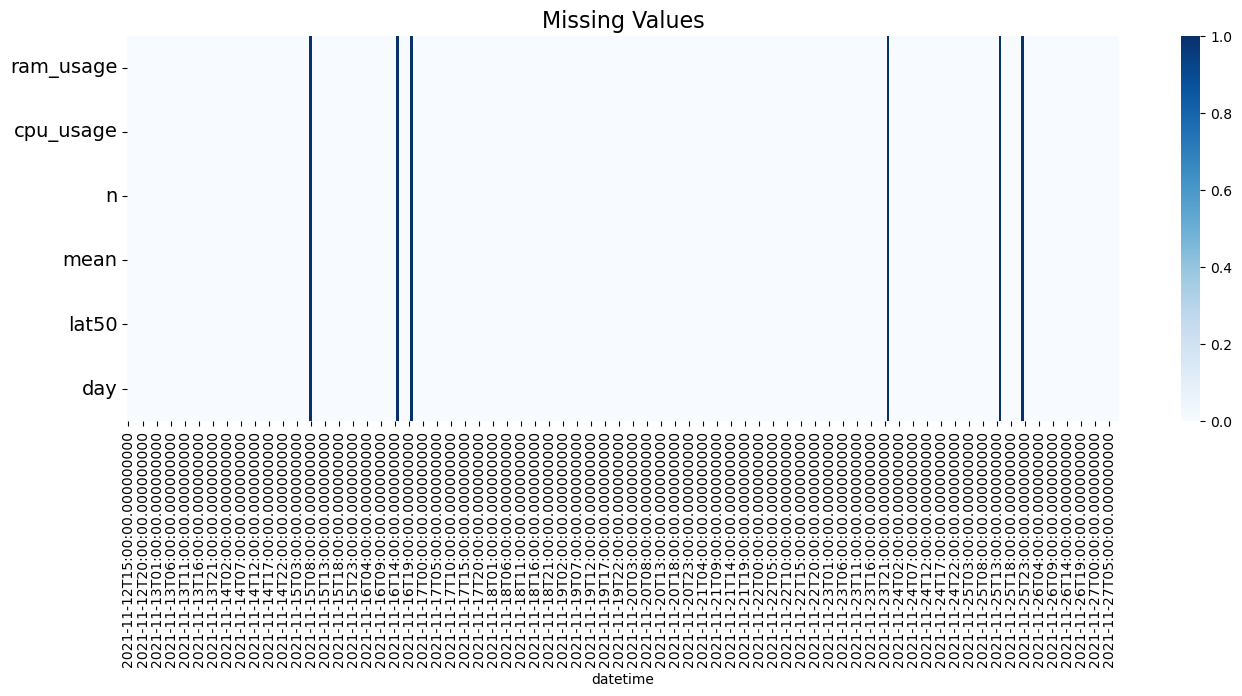

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Interpolate to fill the null values in the df

In [20]:
print(f"Frequency: {frequency}\nN. null: {df_max.isna().sum()[0]} \n% null over total: {df_max.isna().sum()[0]/len(df_max)*100:.2f}%")

Frequency: 1h
N. null: 6 
% null over total: 1.69%


C:\Users\Alice Piemonti\AppData\Local\Temp\ipykernel_35056\61170822.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Frequency: {frequency}\nN. null: {df_max.isna().sum()[0]} \n% null over total: {df_max.isna().sum()[0]/len(df_max)*100:.2f}%")


In [21]:
interpolated_df = df_max.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

## LSTM multivariate forecasting

Forecast multiple related time series simultaneously. Related time series here are: 'cpu_usage', 'ram_usage', 'cpu_limit', 'ram_limit'

In [22]:
# define train and test size
train_size = int(0.7 * len(interpolated_df))
test_size = len(interpolated_df) - train_size

split_point = interpolated_df.iloc[train_size].name
split_point

Timestamp('2021-11-22 22:00:00')

### Forecast RAM usage using covariates

Training with covariates means using additional information (covariates) that may help improve the accuracy of the forecast for the main time series of interest. These covariates are external variables that are not being forecasted themselves but are used to inform the forecast of the primary series.

In this example covariates are: 'ram_limit', 'cpu_limit', 'ram_usage', 'n', 'mean', 'lat50', 'day', 'hour'

N.B. this is an example of how to use covariates. You can't use covariates this way in a real world scenario because future ram_limit, cpu_usage, [...], are not known in advance and must be forecasted first.

In [23]:
# create covariates
covariates = interpolated_df.drop(columns=['ram_usage'])
covariates = TimeSeries.from_dataframe(covariates.reset_index(), 'datetime')
covariates

<TimeSeries (DataArray) (datetime: 354, component: 8, sample: 1)> Size: 23kB
array([[[4.0960000e+03],
        [4.0000000e+00],
        [1.3583020e+00],
        ...,
        [6.7428077e+07],
        [1.2000000e+01],
        [1.5000000e+01]],

       [[3.5840000e+03],
        [4.0000000e+00],
        [1.3854980e+00],
        ...,
        [6.8162522e+07],
        [1.2000000e+01],
        [1.6000000e+01]],

       [[3.0720000e+03],
        [4.0000000e+00],
        [1.3823580e+00],
        ...,
...
        ...,
        [9.6467143e+07],
        [2.7000000e+01],
        [6.0000000e+00]],

       [[2.8160000e+03],
        [1.5000000e+00],
        [8.1590200e-01],
        ...,
        [1.5788169e+07],
        [2.7000000e+01],
        [7.0000000e+00]],

       [[4.0960000e+03],
        [1.0000000e+00],
        [5.7969700e-01],
        ...,
        [4.4146120e+06],
        [2.7000000e+01],
        [8.0000000e+00]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 3kB 2021-11-12T15:00:00 ... 2021-11-...
  * component  (component) object 64B 'ram_limit' 'cpu_limit' ... 'day' 'hour'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
covariates.components

Index(['ram_limit', 'cpu_limit', 'cpu_usage', 'n', 'mean', 'lat50', 'day',
       'hour'],
      dtype='object', name='component')

In [25]:
# define target series to forecast
series = TimeSeries.from_dataframe(interpolated_df.reset_index(), 'datetime', ['ram_usage'])

# train test split
train, test = series.split_after(split_point)
cov_train, cov_test = covariates.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)

transformer_cov = Scaler()
cov_train = transformer_cov.fit_transform(cov_train)
cov_test = transformer_cov.transform(cov_test)
covariates_transformed = transformer_cov.transform(covariates)

In [30]:
# define early stopping parameters
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper], "log_every_n_steps": 5}

# build model
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM_memory_usage",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=5,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)

# train model
my_model.fit(
    train_transformed,
    future_covariates=covariates_transformed,
    val_series=val_transformed,
    val_future_covariates=covariates_transformed,
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.5 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=8, n_epochs=300, optimizer_kwargs={'lr': 0.001}, model_name=LSTM_memory_usage, log_tensorboard=True, random_state=42, input_chunk_length=5, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002A5FC7DE890>], 'log_every_n_steps': 5})

In [31]:
def eval_model(model):
    pred_series = model.predict(n=test_size - 1, future_covariates=covariates_transformed)

    
    # Plot the forecast
    f, ax = plt.subplots(1)
    f.set_figheight(6)
    f.set_figwidth(15)

    # inverse transform the predictions
    pred_series = transformer.inverse_transform(pred_series)

    mape_score = mape(pred_series, test)/100
    mae_score = mae(pred_series, test)
    rmse_score = rmse(pred_series, test)
    
    # Plot the data
    ax.plot(interpolated_df.index[:train_size], series[:train_size].values(), label="Training Set", color="steelblue")
    ax.plot(interpolated_df.index[train_size:], series[train_size:].values(), label="Test Set", color="orange")
    ax.plot(interpolated_df.index[train_size + 1:], pred_series.values(), label="Predictions", color='green')
    plt.title(f'Prediction \n MAPE: {mape_score:.2f}, MAE: {mae_score:.2f}, RMSE: {rmse_score:.2f}', fontsize=14)

    plt.xlabel('Time')
    plt.ylabel('Memory usage (MB)') 
    plt.legend()

    plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

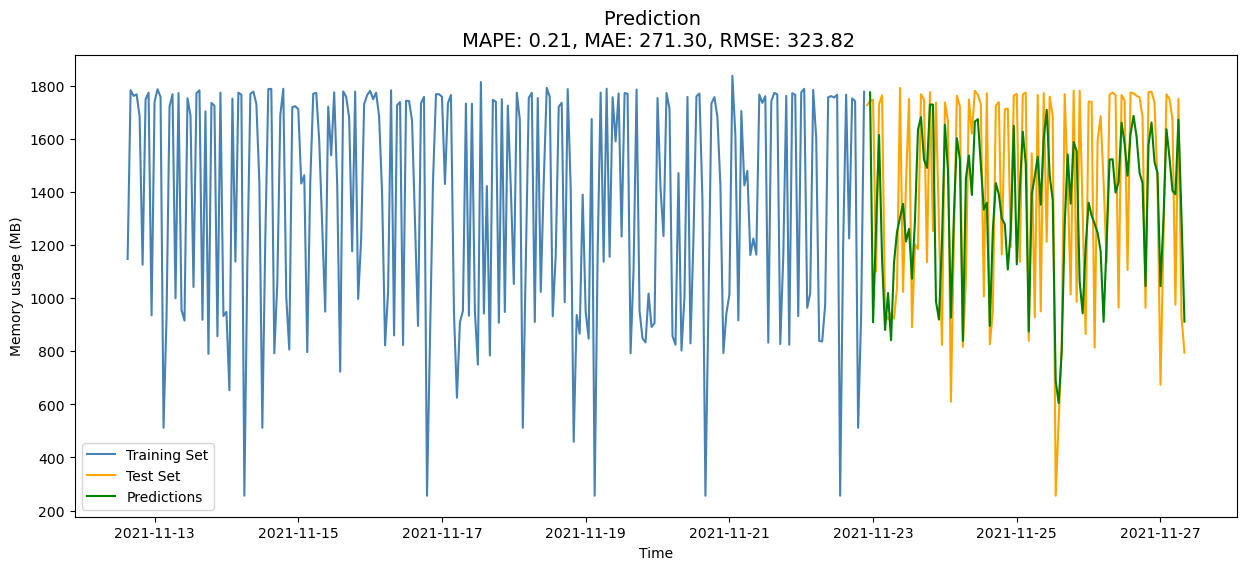

In [32]:
best_model = RNNModel.load_from_checkpoint(model_name="LSTM_memory_usage", best=True)
eval_model(best_model)